In [1]:
from pyspark.sql import SparkSession    # main entry point for DataFrame and SQL functionality
from pyspark.sql.functions import col    # for returning a column based on a given column name
from pyspark.sql.functions import lit    # for adding a new column to PySpark DataFrame
from pyspark.ml.classification import LogisticRegression    # for classification model
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler    # for preparing data for classification
from pyspark.ml.evaluation import MulticlassClassificationEvaluator    # for evaluating classification models
from pyspark.ml import Pipeline
import pandas as pd   # for data frames
import numpy as np    # for arrays
import time           # for timing cells  
import matplotlib.pyplot as plt # plotting graphs

In [2]:
spark = SparkSession.builder.appName('Logistic_Regression').getOrCreate()
spark

In [3]:
ground_truth_columns = ['userID', 'trackID', 'ground_truth']
ground_truth_df = pd.read_csv('test2_new.txt', sep='|', names=ground_truth_columns)
ground_truth_df

,userID,trackID,ground_truth
0,200031,30877,1
1,200031,8244,1
2,200031,130183,0
3,200031,198762,0
4,200031,34503,1
...,...,...,...
5995,212234,137371,0
5996,212234,42375,0
5997,212234,277867,1
5998,212234,83093,1


In [4]:
scores_columns = ['userID', 'trackID', 'album_score', 'artist_score', 'genre_score']
scores_df = pd.read_csv('genre_test.txt', sep='|', names=scores_columns)
scores_df

,userID,trackID,album_score,artist_score,genre_score
0,199810,208019,0,0,0.0
1,199810,74139,0,0,80.0
2,199810,9903,0,0,0.0
3,199810,242681,0,0,0.0
4,199810,18515,0,70,0.0
...,...,...,...,...,...
119995,249010,72192,0,0,0.0
119996,249010,86104,0,0,0.0
119997,249010,186634,90,90,0.0
119998,249010,293818,0,0,0.0


In [5]:
ratings_df = ground_truth_df.merge(scores_df, on=['userID', 'trackID']).fillna(0)    # inner join by default
ratings_df

,userID,trackID,ground_truth,album_score,artist_score,genre_score
0,200031,30877,1,90,50,85.0
1,200031,8244,1,90,0,85.0
2,200031,130183,0,0,0,0.0
3,200031,198762,0,0,0,90.0
4,200031,34503,1,90,50,85.0
...,...,...,...,...,...,...
5995,212234,137371,0,0,0,0.0
5996,212234,42375,0,0,0,0.0
5997,212234,277867,1,90,90,0.0
5998,212234,83093,1,90,90,0.0


In [6]:
ratings_df.to_csv('ratings.csv', index=None)    # index=None means index column is not written to csv

In [7]:
ratings_df = spark.read.csv('ratings.csv', header=True, inferSchema=True)    # inferSchema scans csv twice to get datatype of each column
ratings_df
ratings_df.count()
ratings_columns = ratings_df.columns
pd.DataFrame(ratings_df.take(6000), columns=ratings_columns).groupby('ground_truth').count()

,userID,trackID,album_score,artist_score,genre_score
ground_truth,,,,,
0,3000,3000,3000,3000,3000
1,3000,3000,3000,3000,3000


In [8]:
ratings_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: integer (nullable = true)
 |-- album_score: integer (nullable = true)
 |-- artist_score: integer (nullable = true)
 |-- genre_score: double (nullable = true)



In [9]:
ratings_df = ratings_df.withColumn('ground_truth', ratings_df['ground_truth'].cast('string'))
ratings_df.dtypes

[('userID', 'int'),
 ('trackID', 'int'),
 ('ground_truth', 'string'),
 ('album_score', 'int'),
 ('artist_score', 'int'),
 ('genre_score', 'double')]

In [10]:
feature_columns = ['album_score', 'artist_score', 'genre_score']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

In [11]:
label_column = 'ground_truth'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

In [12]:
pipeline = Pipeline(stages=stages)               # initialize the pipeline
pipeline_model = pipeline.fit(ratings_df)        # fit the pipeline model
train_df = pipeline_model.transform(ratings_df)  # transform the input DF with the pipeline model

selected_columns = ['label', 'features'] + ratings_columns
train_df = train_df.select(selected_columns)
train_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: string (nullable = true)
 |-- album_score: integer (nullable = true)
 |-- artist_score: integer (nullable = true)
 |-- genre_score: double (nullable = true)



In [13]:
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

,0,1,2,3,4
label,1,1,0,0,1
features,"[90.0, 50.0, 85.0]","[90.0, 0.0, 85.0]","(0.0, 0.0, 0.0)","[0.0, 0.0, 90.0]","[90.0, 50.0, 85.0]"
userID,200031,200031,200031,200031,200031
trackID,30877,8244,130183,198762,34503
ground_truth,1,1,0,0,1
album_score,90,90,0,0,90
artist_score,50,0,0,0,50
genre_score,85,85,0,90,85


In [14]:
train_df, test_df = train_df.randomSplit([0.7, 0.3], seed=2021)
print(f'Training Dataset Count: {train_df.count()}')
print(f'Test Dataset Count: {test_df.count()}')

Training Dataset Count: 4194
Test Dataset Count: 1806


In [15]:
#Load in and prepare prediction file

prediction_df = spark.read.csv('genre_test.txt', sep='|', inferSchema=True)    # inferSchema scans csv twice to get datatype of each column
prediction_df.count()

120000

In [16]:
prediction_df = prediction_df.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "trackID").withColumnRenamed("_c2", "albumScore").withColumnRenamed("_c3", "artistScore").withColumnRenamed("_c4", "genreScore")
prediction_columns = prediction_df.columns
prediction_columns

['userID', 'trackID', 'albumScore', 'artistScore', 'genreScore']

In [17]:
prediction_df = prediction_df.withColumn('prediction', lit('0'))
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0,0,0,0,0
artistScore,0,0,0,0,70
genreScore,0,80,0,0,0
prediction,0,0,0,0,0


In [18]:
prediction_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: integer (nullable = true)
 |-- artistScore: integer (nullable = true)
 |-- genreScore: double (nullable = true)
 |-- prediction: string (nullable = false)



In [19]:
feature_columns = ['albumScore', 'artistScore','genreScore']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

label_column = 'prediction'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

prediction_pipeline = Pipeline(stages=stages)                       # initialize the pipeline
prediction_pipeline_model = prediction_pipeline.fit(prediction_df)  # fit the pipeline model
prediction_df = prediction_pipeline_model.transform(prediction_df)  # transform the input DF with the pipeline model

selected_columns = ['label', 'features'] + prediction_columns
prediction_df = prediction_df.select(selected_columns)
prediction_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: integer (nullable = true)
 |-- artistScore: integer (nullable = true)
 |-- genreScore: double (nullable = true)



In [20]:
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(0.0, 0.0, 0.0)","[0.0, 0.0, 80.0]","(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0)","[0.0, 70.0, 0.0]"
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0,0,0,0,0
artistScore,0,0,0,0,70
genreScore,0,80,0,0,0


In [21]:
# Model- Logistic Regression

from pyspark.ml.classification import LogisticRegression

start_time = time.time()

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)  # initialize a logistic regression model
lr_model = lr.fit(train_df)                                                         # fit the training data with the model

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 5.16 seconds.


In [22]:
lr_model.coefficients

DenseVector([0.0488, 0.0309, 0.0065])

In [23]:
beta = np.sort(lr_model.coefficients)    # return a sorted copy of an array
beta

array([0.00649185, 0.03092397, 0.04876036])

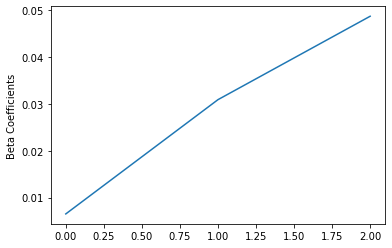

In [24]:
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [25]:
training_summary = lr_model.summary    # get summary (e.g. accuracy/precision/recall, objective history, total iterations) of model trained on the training set
roc = training_summary.roc.toPandas()    # get roc DF
roc

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.005291
2,0.000000,0.018759
3,0.000000,0.020202
4,0.000000,0.021645
...,...,...
143,0.320567,0.876383
144,0.338534,0.878788
145,0.343262,0.879750
146,1.000000,1.000000


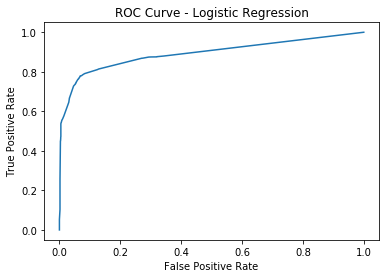

Training Set AUC = 0.8923435639747694


In [26]:
plt.plot(roc.FPR, roc.TPR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()
print(f'Training Set AUC = {training_summary.areaUnderROC}')

In [27]:
predictions = lr_model.transform(test_df)    # transform test_df with logistic regression model
predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200032| 110262|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200032| 218377|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200055| 175557|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200055| 233815|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200065| 227397|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200106| 181408|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200166|  58283|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200191| 156250|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200263| 132785|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200279|  72878|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200360|  44

In [28]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_predictions = predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 227283|  0.0|[0.16490778749356...|[-1.6221556988902...|       1.0|
|200031|  30877|  1.0|[0.00760732569472...|[-4.8710071797606...|       1.0|
|200031|  34503|  1.0|[0.00760732569472...|[-4.8710071797606...|       1.0|
|200032| 218377|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200032| 110262|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
|200055| 175557|  0.0|[0.83416406974341...|[1.61543118167508...|       0.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [29]:
logistic_predictions = lr_model.transform(prediction_df)    # transform prediction_df with logistic regression model
logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.83416406974341...|[1.61543118167508...|       0.0|
|199810|  74139|[0.74952545008464...|[1.09608295483047...|       0.0|
|199810|   9903|[0.83416406974341...|[1.61543118167508...|       0.0|
|199810| 242681|[0.83416406974341...|[1.61543118167508...|       0.0|
|199810|  18515|[0.36603921503131...|[-0.5492466266064...|       1.0|
|199810| 105760|[0.15616099532553...|[-1.6870742272457...|       1.0|
|199812| 276940|[0.83416406974341...|[1.61543118167508...|       0.0|
|199812| 142408|[0.00103496728930...|[-6.8723499540615...|       1.0|
|199812| 130023|[0.00103496728930...|[-6.8723499540615...|       1.0|
|199812|  29189|[0.74952545008464...|[1.09608295483047...|       0.0|
|199812| 223706|[0.11959048095088...|[-1.9963139141431...|       1.0|
|199812| 211361|[0.8

In [30]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_logistic_predictions = logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_logistic_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810|   9903|[0.83416406974341...|[1.61543118167508...|       0.0|
|199810| 208019|[0.83416406974341...|[1.61543118167508...|       0.0|
|199810| 242681|[0.83416406974341...|[1.61543118167508...|       0.0|
|199810|  74139|[0.74952545008464...|[1.09608295483047...|       0.0|
|199810|  18515|[0.36603921503131...|[-0.5492466266064...|       1.0|
|199810| 105760|[0.15616099532553...|[-1.6870742272457...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [31]:
pd_sort_logistic_predictions = sort_logistic_predictions.toPandas().fillna(0.0)    # create a pandas df
pd_sort_logistic_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8341640697434147, 0.16583593025658516]","[1.6154311816750841, -1.6154311816750841]",0.0
1,199810,9903,"[0.8341640697434147, 0.16583593025658516]","[1.6154311816750841, -1.6154311816750841]",0.0
2,199810,242681,"[0.8341640697434147, 0.16583593025658516]","[1.6154311816750841, -1.6154311816750841]",0.0
3,199810,74139,"[0.749525450084649, 0.2504745499153509]","[1.0960829548304731, -1.0960829548304731]",0.0
4,199810,18515,"[0.36603921503131737, 0.6339607849686827]","[-0.5492466266064568, 0.5492466266064568]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8341640697434147, 0.16583593025658516]","[1.6154311816750841, -1.6154311816750841]",0.0
119996,249010,293818,"[0.8341640697434147, 0.16583593025658516]","[1.6154311816750841, -1.6154311816750841]",0.0
119997,249010,110470,"[0.003848720275219599, 0.9961512797247805]","[-5.556158436327745, 5.556158436327745]",1.0
119998,249010,186634,"[0.003848720275219599, 0.9961512797247805]","[-5.556158436327745, 5.556158436327745]",1.0


In [32]:
columns_to_write = ['userID', 'trackID']
pd_sort_logistic_predictions.to_csv('log_reg_genre_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [33]:
f_lr_predictions = open('log_reg_genre_predictions.csv')                  
f_lr_final_predictions = open('log_reg_genre_final_predictions.csv', 'w')
# Write header
f_lr_final_predictions.write('TrackID,Predictor\n')

18

In [34]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

start_time = time.time()

# Go through each line of the predictions file
for line in f_lr_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list 
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track
    
    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i
        
    track_id_out_vec[i] = track_id_out          # add trackID to trackID array
        
    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID
    
    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions 
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):            
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)
        
        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_lr_final_predictions.write(out_str + '\n')

        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

f_lr_predictions.close()
f_lr_final_predictions.close()

Done! Time elapsed - 2.03 seconds.
